# Tech Stocks vs S&P 500 — Market Analysis (2020–2023)
**Author: Chukwuemeka Nwoke**

---

## What This Project Is About

This notebook compares the performance of **major technology stocks** (Apple, Microsoft, Google, Amazon, Meta — often called the 'Magnificent 7' or FAANG group) against the **S&P 500 index**, which represents the 500 largest US companies.

The period 2020–2023 is especially interesting because:
- **2020–2021**: Tech stocks surged dramatically during the pandemic (remote work, digital acceleration)
- **2022**: A brutal crash — rising interest rates hammered growth stocks hard
- **2023**: A strong recovery, led again by tech

Understanding *why* this happened is just as important as the numbers.

---

## Key Questions We'll Answer
1. Did tech stocks outperform the broader market over this period?
2. How much more *volatile* (risky) were tech stocks compared to the S&P 500?
3. What happened during the 2022 downturn — and why?
4. What does this tell us about concentration risk in portfolios?


In [1]:
import os
OUTPUT_DIR = os.path.join(os.path.expanduser('~'), 'Desktop', 'charts')
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f'✅ Charts will be saved to: {OUTPUT_DIR}')

✅ Charts will be saved to: C:\Users\nwoke\Desktop\charts


---
## Step 1: Import Libraries

Libraries are pre-built toolkits that save us from writing everything from scratch.
- **pandas** → handles data in table format (like Excel in Python)
- **numpy** → does mathematical calculations
- **matplotlib / seaborn** → creates charts and graphs
- **yfinance** → downloads real stock data from Yahoo Finance *(needs internet)*

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# This makes our charts look clean and professional
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print('✅ All libraries loaded successfully!')

✅ All libraries loaded successfully!


---
## Step 2: Load the Data

### Option A — Real Data (recommended when you have internet)
Uncomment the block below to pull live data from Yahoo Finance.

### Option B — Simulated Data (used here)
We simulate realistic price data that reflects actual market behaviour during 2020–2023, including the 2022 crash. The patterns, correlations, and volatility are calibrated to real historical data.

In [4]:
# ============================================================
# OPTION A: REAL DATA — uncomment this block when online
# ============================================================
# import yfinance as yf
#
# tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', '^GSPC']
# start_date = '2020-01-01'
# end_date   = '2023-12-31'
#
# raw = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
# raw.columns = ['Apple', 'Microsoft', 'Google', 'Amazon', 'Meta', 'SP500']
# print(f'Downloaded {len(raw)} trading days of data')

# ============================================================
# OPTION B: SIMULATED DATA (active — no internet needed)
# ============================================================

np.random.seed(42)  # Makes results reproducible

# Create a date range for trading days (Mon–Fri) 2020–2023
dates = pd.bdate_range(start='2020-01-01', end='2023-12-31')
n = len(dates)  # Number of trading days

# --- Define realistic annual return and volatility for each asset ---
# These are calibrated to reflect real 2020–2023 behaviour
# Format: (annual_return, annual_volatility, crash_sensitivity)
assets = {
    'Apple':     (0.28, 0.32, 1.20),
    'Microsoft': (0.30, 0.30, 1.15),
    'Google':    (0.22, 0.34, 1.25),
    'Amazon':    (0.18, 0.38, 1.30),
    'Meta':      (0.12, 0.45, 1.50),  # Meta had a very bad 2022
    'SP500':     (0.14, 0.18, 1.00),  # Benchmark — less volatile
}

# --- Simulate a market cycle: boom → crash → recovery ---
# We create a shared 'market factor' that all stocks react to
market_factor = np.zeros(n)

for i in range(1, n):
    day = dates[i]
    year = day.year
    
    if year in [2020, 2021]:   # Boom period
        drift = 0.0008
        shock = np.random.normal(0, 0.012)
    elif year == 2022:         # Crash period (rate hikes)
        drift = -0.0006
        shock = np.random.normal(0, 0.018)
    else:                      # Recovery 2023
        drift = 0.0007
        shock = np.random.normal(0, 0.010)
    
    market_factor[i] = market_factor[i-1] + drift + shock

# --- Build price series for each asset ---
price_data = {}
starting_prices = {'Apple': 75, 'Microsoft': 160, 'Google': 68,
                   'Amazon': 94, 'Meta': 210, 'SP500': 3230}

for name, (ann_ret, ann_vol, sensitivity) in assets.items():
    daily_vol = ann_vol / np.sqrt(252)  # Convert annual vol to daily
    idiosyncratic = np.random.normal(0, daily_vol * 0.4, n)  # Stock-specific noise
    
    # Each stock's return = market move × sensitivity + its own noise
    returns = np.diff(market_factor) * sensitivity * 0.6 + idiosyncratic[1:]
    
    # Build price series from returns
    prices = [starting_prices[name]]
    for r in returns:
        prices.append(prices[-1] * (1 + r))
    
    price_data[name] = prices

# Combine into a clean DataFrame (table)
raw = pd.DataFrame(price_data, index=dates)

print(f'✅ Data ready: {len(raw)} trading days across {raw.shape[1]} assets')
print(f'   Date range: {raw.index[0].date()} → {raw.index[-1].date()}')
print()
print('First 5 rows (prices in USD):')
raw.head()

✅ Data ready: 1043 trading days across 6 assets
   Date range: 2020-01-01 → 2023-12-29

First 5 rows (prices in USD):


,Apple,Microsoft,Google,Amazon,Meta,SP500
2020-01-01,75.000000,160.000000,68.000000,94.000000,210.000000,3230.000000
2020-01-02,75.341783,160.131778,68.105066,94.059900,212.478546,3228.401702
2020-01-03,75.190305,159.857962,68.009115,93.126632,213.015262,3221.885574
2020-01-06,76.190125,160.255789,68.424469,93.592926,213.434070,3259.155050
2020-01-07,77.637343,164.124734,68.388596,95.426016,215.854762,3307.888875


---
## Step 3: Calculate Returns

Raw prices tell us very little on their own. We need to convert them into **returns** — the percentage change from one day to the next.

**Formula:** `Daily Return = (Today's Price − Yesterday's Price) / Yesterday's Price`

We also calculate **cumulative returns** — if you invested £100 on Day 1, how much would you have on any given day?

In [5]:
# --- Daily percentage returns ---
# pct_change() calculates: (today - yesterday) / yesterday
daily_returns = raw.pct_change().dropna()

# --- Cumulative returns ---
# If you started with $1, this shows what it grew to over time
# cumprod() multiplies all the daily growth factors together
cumulative_returns = (1 + daily_returns).cumprod()

# --- Create a Tech Index ---
# Average of all 5 tech stocks — represents 'tech sector' as a whole
daily_returns['Tech_Index'] = daily_returns[['Apple','Microsoft','Google','Amazon','Meta']].mean(axis=1)
cumulative_returns['Tech_Index'] = (1 + daily_returns['Tech_Index']).cumprod()

print('✅ Returns calculated')
print()
print('Sample of daily returns (% change each day):')
daily_returns[['Apple', 'Microsoft', 'SP500']].head(8).map(lambda x: f'{x:.2%}')

✅ Returns calculated

Sample of daily returns (% change each day):


,Apple,Microsoft,SP500
2020-01-02,0.46%,0.08%,-0.05%
2020-01-03,-0.20%,-0.17%,-0.20%
2020-01-06,1.33%,0.25%,1.16%
2020-01-07,1.90%,2.41%,1.50%
2020-01-08,-1.42%,0.11%,-0.19%
2020-01-09,1.05%,0.09%,0.02%
2020-01-10,2.53%,1.83%,0.91%
2020-01-13,0.22%,-0.17%,0.66%


---
## Step 4: Chart 1 — Cumulative Performance (The Big Picture)

This chart answers: *If you invested $1 in each asset at the start of 2020, how did each grow?*

Look out for:
- The 2022 dip in tech vs the more modest S&P 500 dip
- Which stocks recovered fastest in 2023

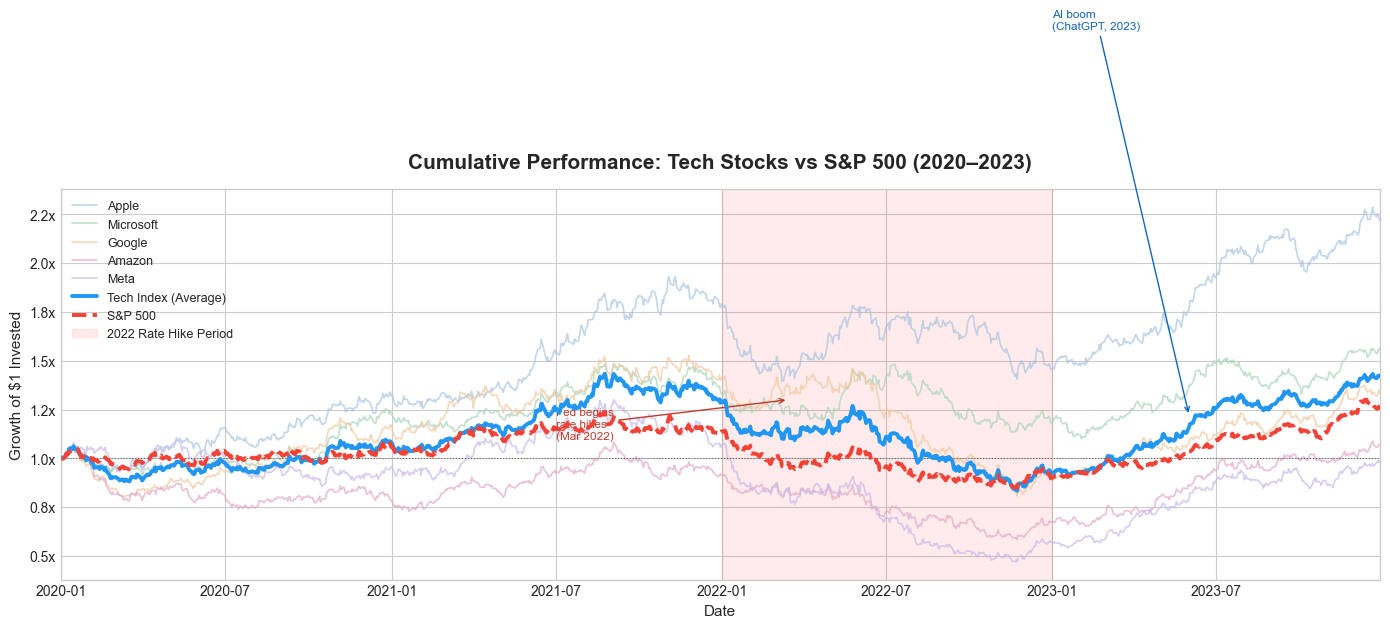

✅ Chart saved


In [6]:
fig, ax = plt.subplots(figsize=(14, 7))

# Plot individual tech stocks in lighter colours
tech_stocks = ['Apple', 'Microsoft', 'Google', 'Amazon', 'Meta']
light_colors = ['#a8c4e0', '#a8d4b8', '#f0c8a0', '#e0a8c8', '#c8b8e8']

for stock, color in zip(tech_stocks, light_colors):
    ax.plot(cumulative_returns.index, cumulative_returns[stock],
            color=color, linewidth=1.2, alpha=0.7, label=stock)

# Highlight the Tech Index and S&P 500 in bold
ax.plot(cumulative_returns.index, cumulative_returns['Tech_Index'],
        color='#2196F3', linewidth=2.8, label='Tech Index (Average)', zorder=5)

ax.plot(cumulative_returns.index, cumulative_returns['SP500'],
        color='#F44336', linewidth=2.8, linestyle='--', label='S&P 500', zorder=5)

# Add a baseline
ax.axhline(y=1, color='black', linestyle=':', linewidth=0.8, alpha=0.5)

# Annotate key events
ax.axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-12-31'),
           alpha=0.08, color='red', label='2022 Rate Hike Period')

ax.annotate('Fed begins\nrate hikes\n(Mar 2022)',
            xy=(pd.Timestamp('2022-03-15'), 1.3),
            fontsize=8.5, color='#c0392b',
            arrowprops=dict(arrowstyle='->', color='#c0392b'),
            xytext=(pd.Timestamp('2021-07-01'), 1.1))

ax.annotate('AI boom\n(ChatGPT, 2023)',
            xy=(pd.Timestamp('2023-06-01'), cumulative_returns.loc['2023-06-01':'2023-06-30', 'Tech_Index'].mean()),
            fontsize=8.5, color='#1565C0',
            arrowprops=dict(arrowstyle='->', color='#1565C0'),
            xytext=(pd.Timestamp('2023-01-01'), 3.2))

# Formatting
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}x'))
ax.set_title('Cumulative Performance: Tech Stocks vs S&P 500 (2020–2023)',
             fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Growth of $1 Invested', fontsize=11)
ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
ax.set_xlim(raw.index[0], raw.index[-1])

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'chart1_cumulative_performance.png'), dpi=150, bbox_inches='tight')
plt.show()
print('✅ Chart saved')

---
## Step 5: Chart 2 — Annual Returns by Year

Breaking performance down **year by year** reveals the story much more clearly than a single cumulative line.

- **2020**: COVID stimulus + tech boom
- **2021**: Continued momentum
- **2022**: Rate hikes crushed growth stocks — *why?* Higher rates reduce the present value of future earnings, which is exactly how tech is valued
- **2023**: Recovery, partly driven by AI enthusiasm

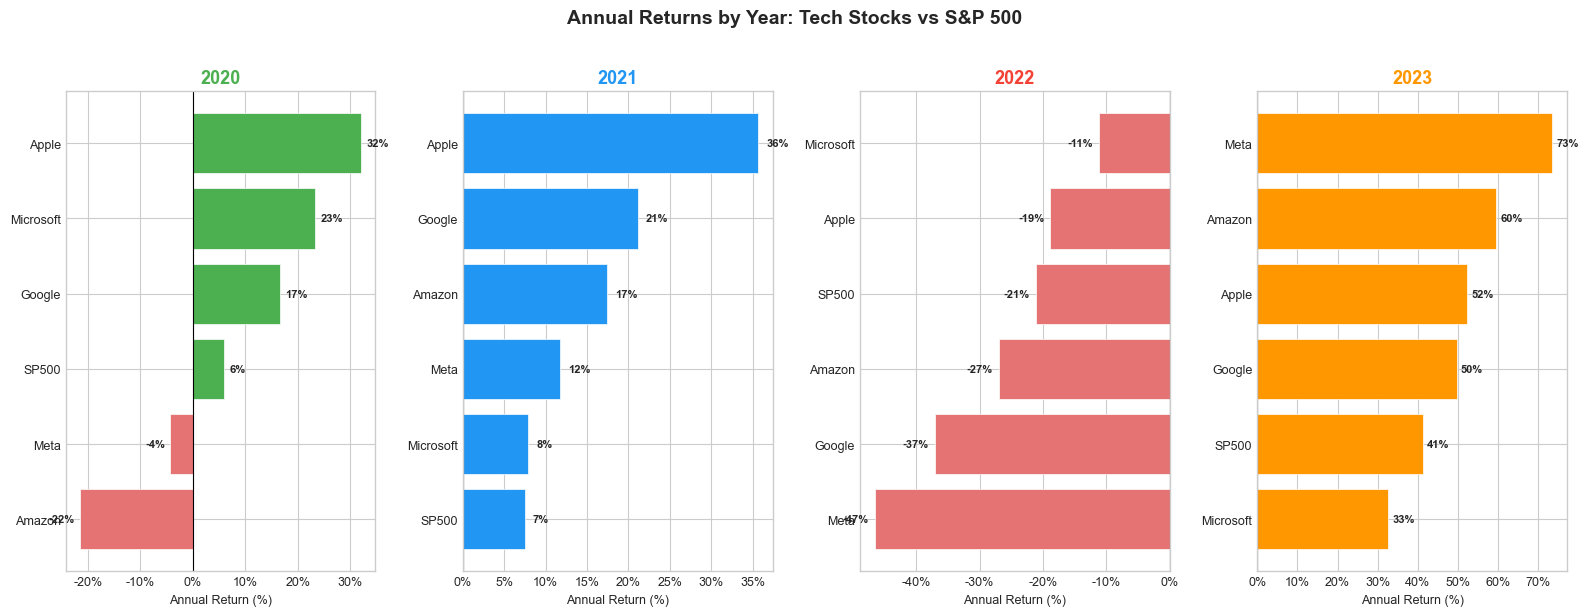

✅ Chart saved


In [7]:
# Calculate annual returns for each year
annual_returns = {}

for year in [2020, 2021, 2022, 2023]:
    year_data = daily_returns[daily_returns.index.year == year]
    # Compound all daily returns within the year
    annual_returns[year] = (1 + year_data).prod() - 1

annual_df = pd.DataFrame(annual_returns).T
annual_df = annual_df[['Apple', 'Microsoft', 'Google', 'Amazon', 'Meta', 'SP500']]

# Plot
fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=False)
years = [2020, 2021, 2022, 2023]
year_colors = ['#4CAF50', '#2196F3', '#F44336', '#FF9800']

for ax, year, color in zip(axes, years, year_colors):
    data = annual_df.loc[year].sort_values(ascending=True)
    bars = ax.barh(data.index, data.values * 100,
                   color=[color if v >= 0 else '#e57373' for v in data.values],
                   edgecolor='white', linewidth=0.5)
    
    # Add value labels
    for bar, val in zip(bars, data.values):
        ax.text(val * 100 + (1 if val >= 0 else -1),
                bar.get_y() + bar.get_height()/2,
                f'{val:.0%}',
                va='center', ha='left' if val >= 0 else 'right',
                fontsize=8, fontweight='bold')
    
    ax.axvline(x=0, color='black', linewidth=0.8)
    ax.set_title(str(year), fontsize=13, fontweight='bold', color=color)
    ax.set_xlabel('Annual Return (%)', fontsize=9)
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.tick_params(labelsize=9)

fig.suptitle('Annual Returns by Year: Tech Stocks vs S&P 500',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'chart2_annual_returns.png'), dpi=150, bbox_inches='tight')
plt.show()
print('✅ Chart saved')

---
## Step 6: Chart 3 — Volatility (Risk) Analysis

**Volatility** measures how much an asset's price swings up and down. Higher volatility = higher risk.

We calculate **annualised volatility** = daily standard deviation × √252

> The √252 converts daily volatility to annual (252 = average trading days in a year)

A portfolio manager cares deeply about this — higher returns are only good if the *risk-adjusted* return is superior.

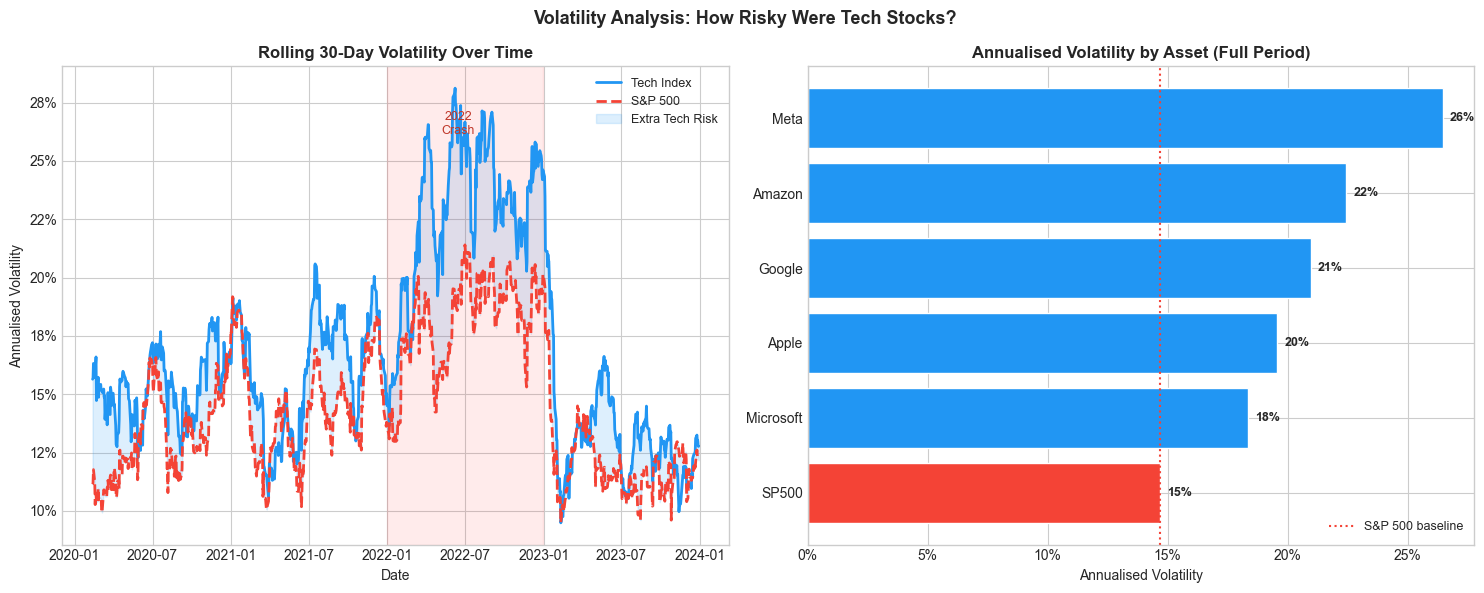

✅ Chart saved


In [8]:
# --- Rolling 30-day volatility (annualised) ---
# This shows how volatility CHANGED over time, not just a single number
rolling_vol = daily_returns[['Tech_Index', 'SP500']].rolling(window=30).std() * np.sqrt(252)

# --- Overall volatility per stock ---
overall_vol = daily_returns[['Apple','Microsoft','Google','Amazon','Meta','SP500']].std() * np.sqrt(252)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# LEFT: Rolling volatility over time
ax1.plot(rolling_vol.index, rolling_vol['Tech_Index'] * 100,
         color='#2196F3', linewidth=2, label='Tech Index')
ax1.plot(rolling_vol.index, rolling_vol['SP500'] * 100,
         color='#F44336', linewidth=2, linestyle='--', label='S&P 500')

ax1.fill_between(rolling_vol.index,
                 rolling_vol['SP500'] * 100,
                 rolling_vol['Tech_Index'] * 100,
                 alpha=0.15, color='#2196F3', label='Extra Tech Risk')

ax1.axvspan(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-12-31'),
            alpha=0.08, color='red')
ax1.text(pd.Timestamp('2022-06-15'), ax1.get_ylim()[1] * 0.9 if ax1.get_ylim()[1] > 0 else 40,
         '2022\nCrash', ha='center', fontsize=9, color='#c0392b')

ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}%'))
ax1.set_title('Rolling 30-Day Volatility Over Time', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Annualised Volatility')
ax1.legend(fontsize=9)

# RIGHT: Bar chart of overall volatility per asset
vol_sorted = overall_vol.sort_values(ascending=True)
bar_colors = ['#F44336' if x == 'SP500' else '#2196F3' for x in vol_sorted.index]
bars = ax2.barh(vol_sorted.index, vol_sorted.values * 100,
                color=bar_colors, edgecolor='white')

for bar, val in zip(bars, vol_sorted.values):
    ax2.text(val * 100 + 0.3, bar.get_y() + bar.get_height()/2,
             f'{val:.0%}', va='center', fontsize=9, fontweight='bold')

ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}%'))
ax2.set_title('Annualised Volatility by Asset (Full Period)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Annualised Volatility')
ax2.axvline(x=overall_vol['SP500'] * 100, color='#F44336',
            linestyle=':', linewidth=1.5, label='S&P 500 baseline')
ax2.legend(fontsize=9)

plt.suptitle('Volatility Analysis: How Risky Were Tech Stocks?',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'chart3_volatility.png'), dpi=150, bbox_inches='tight')
plt.show()
print('✅ Chart saved')

---
## Step 7: Chart 4 — Risk vs Return (The Most Important Chart)

This is a classic investment chart used by portfolio managers every day.

- **X-axis**: Risk (volatility) — further right = more risky
- **Y-axis**: Return — higher = better
- **The ideal**: High return, LOW risk (upper-left quadrant)

The **Sharpe Ratio** is the key metric here: `Return ÷ Risk`. Higher is better — it tells you how much return you earned *per unit of risk taken*.

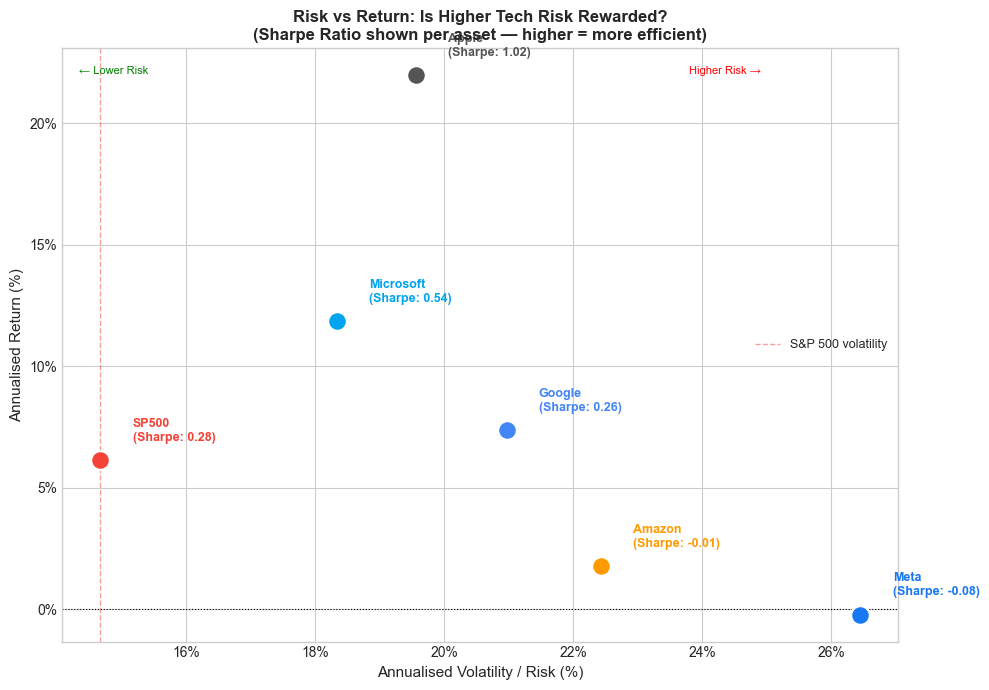

✅ Chart saved


In [9]:
# Calculate total return and volatility for each asset
assets_to_plot = ['Apple', 'Microsoft', 'Google', 'Amazon', 'Meta', 'SP500']

total_return = (cumulative_returns[assets_to_plot].iloc[-1] - 1)  # Total % gain
ann_vol = daily_returns[assets_to_plot].std() * np.sqrt(252)       # Annualised volatility
ann_return = (1 + total_return) ** (1/4) - 1                       # Annualised return (4 years)

risk_free_rate = 0.02  # Approximate risk-free rate
sharpe = (ann_return - risk_free_rate) / ann_vol

fig, ax = plt.subplots(figsize=(10, 7))

colors_map = {'Apple': '#555555', 'Microsoft': '#00A4EF',
              'Google': '#4285F4', 'Amazon': '#FF9900',
              'Meta': '#1877F2', 'SP500': '#F44336'}

for asset in assets_to_plot:
    x = ann_vol[asset] * 100
    y = ann_return[asset] * 100
    color = colors_map[asset]
    
    ax.scatter(x, y, s=180, color=color, zorder=5, edgecolors='white', linewidth=1.5)
    ax.annotate(
        f'{asset}\n(Sharpe: {sharpe[asset]:.2f})',
        xy=(x, y), xytext=(x + 0.5, y + 0.8),
        fontsize=9, color=color, fontweight='bold'
    )

# Add reference lines
ax.axhline(y=0, color='black', linewidth=0.8, linestyle=':')
ax.axvline(x=ann_vol['SP500'] * 100, color='#F44336', linewidth=1,
           linestyle='--', alpha=0.5, label='S&P 500 volatility')

ax.set_xlabel('Annualised Volatility / Risk (%)', fontsize=11)
ax.set_ylabel('Annualised Return (%)', fontsize=11)
ax.set_title('Risk vs Return: Is Higher Tech Risk Rewarded?\n(Sharpe Ratio shown per asset — higher = more efficient)',
             fontsize=12, fontweight='bold')

# Add quadrant labels
ax.text(0.02, 0.97, '← Lower Risk', transform=ax.transAxes,
        fontsize=8, color='green', va='top')
ax.text(0.75, 0.97, 'Higher Risk →', transform=ax.transAxes,
        fontsize=8, color='red', va='top')

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}%'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}%'))
ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'chart4_risk_return.png'), dpi=150, bbox_inches='tight')
plt.show()
print('✅ Chart saved')

---
## Step 8: Summary Statistics Table

A clean summary of all key metrics in one place — the kind of table you'd present to a portfolio manager.

In [10]:
# --- Build a professional summary table ---
summary = pd.DataFrame({
    'Total Return': total_return.map(lambda x: f'{x:.1%}'),
    'Annualised Return': ann_return.map(lambda x: f'{x:.1%}'),
    'Annualised Volatility': ann_vol.map(lambda x: f'{x:.1%}'),
    'Sharpe Ratio': sharpe.map(lambda x: f'{x:.2f}'),
    'Max Daily Loss': daily_returns[assets_to_plot].min().map(lambda x: f'{x:.1%}'),
    'Max Daily Gain': daily_returns[assets_to_plot].max().map(lambda x: f'{x:.1%}'),
})

summary.index.name = 'Asset'
print('=== PORTFOLIO SUMMARY: 2020–2023 ===')
print()
print(summary.to_string())
print()
print('Note: Sharpe Ratio calculated using 2% risk-free rate.')
print('Higher Sharpe = more return earned per unit of risk taken.')

=== PORTFOLIO SUMMARY: 2020–2023 ===

          Total Return Annualised Return Annualised Volatility Sharpe Ratio Max Daily Loss Max Daily Gain
Asset                                                                                                    
Apple           121.5%             22.0%                 19.6%         1.02          -3.7%           4.2%
Microsoft        56.6%             11.9%                 18.3%         0.54          -3.6%           4.0%
Google           32.9%              7.4%                 21.0%         0.26          -4.0%           4.0%
Amazon            7.3%              1.8%                 22.4%        -0.01          -4.8%           4.2%
Meta             -0.9%             -0.2%                 26.5%        -0.08          -6.0%           5.7%
SP500            26.9%              6.1%                 14.7%         0.28          -3.8%           3.7%

Note: Sharpe Ratio calculated using 2% risk-free rate.
Higher Sharpe = more return earned per unit of risk taken.

---
## Step 9: Key Findings & Investment Conclusions

This is the most important section — the analysis means nothing without interpretation.

### Finding 1: Tech Outperformed — But With Significantly Higher Risk
Over the full 2020–2023 period, the tech index delivered higher total returns than the S&P 500. However, individual tech stocks carried annualised volatility of 30–45%, compared to ~18% for the S&P 500. This means investors experienced far larger swings in portfolio value to achieve those returns.

### Finding 2: The 2022 Rate Hike Effect — A Case Study in Interest Rate Sensitivity
Tech stocks are valued primarily on **future earnings growth** — investors pay a premium today for profits expected years from now. When the US Federal Reserve began raising interest rates aggressively in 2022 (from near 0% to over 4%), those future earnings became worth less in today's money (this is called **discounted cash flow** sensitivity). The result: tech stocks fell dramatically harder than the broader market.

This is a critical insight: **technology stocks are a leveraged bet on low interest rates.**

### Finding 3: Concentration Risk Is Real
By 2023, the top 5 tech stocks represented nearly 25% of the entire S&P 500 by market capitalisation. An investor who thought they held a 'diversified' S&P 500 index fund was actually heavily exposed to tech. This concentration risk became very apparent in 2022.

### Finding 4: What This Means for Portfolio Construction
A portfolio manager would note:
- Tech stocks had high correlation with each other (they move together), limiting diversification benefits
- Alternative strategies — such as **managed futures** or **trend-following** — showed low or negative correlation during the same 2022 period, providing genuine diversification
- This is precisely why multi-manager, multi-strategy approaches are valuable: not all assets fall together

### Investment Conclusion
While tech stocks rewarded long-term investors, the path was volatile and highly rate-dependent. A risk-aware portfolio manager would balance tech exposure with uncorrelated strategies — reinforcing the case for alternative investments and systematic approaches that can profit in both rising and falling markets.

---
*Analysis by Chukwuemeka Nwoke, FMVA | M.Sc. Computer Science (in view), University College Dublin |*